<a href="https://colab.research.google.com/github/dpriyabijosh/Depression_detection/blob/main/Bertmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Set UP

In [ ]:
!pip install wordcloud
!pip install tweet-preprocessor
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
%matplotlib inline
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
import torch
import preprocessor as p
from tqdm.notebook import tqdm
tqdm.pandas()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Colab Notebooks"
os.chdir(path)

Mounted at /content/drive


In [ ]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 3.7 MB/s 


In [ ]:
# Import from pre-processing notebook
#from DepressionDetection_preprocessing import *
import import_ipynb
from DepressionDetection_preprocessing import *

# Data Set

In [ ]:
#Load dataset
data_raw = initail_dataload()

# Transform and clean the dataset
#Rename the columns
data_raw.rename(columns={'raw_tweet' :'tweet'},inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_raw.head()

,tweet,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


##2.1 Train Dataset Preparation

2.1.1. With intensive cleaning

In [ ]:
data = data_raw.copy()

In [ ]:
data['tweet'] = data_raw['tweet'].apply(clean_tweet)

In [ ]:
 # Removing empty rows
data = clean_empty_rows(data,'tweet')

Initial size (10314, 2)
Shape after cleaning (10278, 2)


In [ ]:
data.head(5)

,tweet,label
0,real good moment miss much,0
1,read manga,0
3,need send em accountant tomorrow oddly even re...,0
4,add me on myspace myspace com lookthunder,0
5,sleepy good time tonight though,0


2.1.1. With necessary cleaning

In [ ]:
data_partial_clean = data_raw.copy()

In [ ]:
# Tweet pre-processing
def tweet_preprocessing(text):
  text = text.replace("#","")

  # Replace '&amp;' with '&'
  text = re.sub(r'&amp;', '&', text)

  # Remove trailing whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return p.clean(text)

In [ ]:
data_partial_clean['tweet'] = data_partial_clean['tweet'].astype(str).progress_map(tweet_preprocessing)

  0%|          | 0/10314 [00:00<?, ?it/s]

In [ ]:
 # Removing empty rows
data_partial_clean = clean_empty_rows(data_partial_clean,'tweet')

Initial size (10314, 2)
Shape after cleaning (10298, 2)


In [ ]:
data_partial_clean.tail()

,tweet,label
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


## 2.2 Test dataset Preparation


In [ ]:
# Load data and set labels
test_data_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/validation_data.csv', 
                        dtype= {'raw_tweet': str, 'label':int}, nrows=500,  usecols=[0,1])
#Rename the columns
test_data_raw.rename(columns={'raw_tweet' :'tweet'},inplace=True)

test_data_raw.head()

,tweet,label
0,@_TASOfficial_ I really miss XYZ since 2016 i ...,1
1,There's not much an 8 mile depression run can'...,1
2,How to Overcome Depression#WednesdayThoughts #...,0
3,Real Talk #Kanye has never pulled himself full...,0
4,@andrea_r so it would seem. Good if you wanted...,0


##2.2.1 With Intensive Cleaning

In [ ]:
test_data = test_data_raw.copy()

In [ ]:
# Perform Cleaning and Lemmatization
test_data['tweet'] = test_data['tweet'].apply(clean_tweet)

# Removing empty rows
test_data = clean_empty_rows(test_data,'tweet')

Initial size (500, 2)
Shape after cleaning (500, 2)


In [ ]:
test_data.head()

,tweet,label
0,tasofficial really miss xyz since post anime d...,1
1,there be not much mile depression run cannot f...,1
2,how overcome depression aprile,0
3,real talk never pull fully depression suffer m...,0
4,would seem good want multi user video site als...,0


##2.2.1 With Limited Cleaning

In [ ]:
test_data1 = test_data_raw.copy()

In [ ]:
# Perform Cleaning and Lemmatization
test_data1['tweet'] = test_data1['tweet'].apply(clean_tweet)

# Removing empty rows
test_data1 = clean_empty_rows(test_data1,'tweet')

Initial size (500, 2)
Shape after cleaning (500, 2)


In [ ]:
test_data1.head()

,tweet,label
0,tasofficial really miss xyz since post anime d...,1
1,there be not much mile depression run cannot f...,1
2,how overcome depression aprile,0
3,real talk never pull fully depression suffer m...,0
4,would seem good want multi user video site als...,0


##Creating Training dataset

In [ ]:
def createTrainNtest_Dataset(data):
  # Get the lists of sentences and their labels.
  sentences = data.tweet.values
  labels = data.label.values
  return sentences,labels

# Tokenization & Input Formatting

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 65.6 MB/s 
     |████████████████████████████████| 182 kB 70.4 MB/s 


## BERT Tokenizer

In [ ]:
from transformers import BertTokenizer
def load_BertTokenizer():
    print('Loading BERT tokenizer...')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    return tokenizer

In [ ]:
sentences, labels = createTrainNtest_Dataset(data)

In [ ]:
tokenizer = load_BertTokenizer()

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Tokenize Dataset

In [ ]:
# Find maximum length based on our dataset
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  54


In [ ]:
def preprocessing_Bert(sentences,max_length = 512):
    # Load the BERT tokenizer.
    tokenizer = load_BertTokenizer()
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_length,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids,attention_masks
  

In [ ]:
def max_length(data,test_data):
    # Concatenate train data and test data
    all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

    # Encode our concatenated data
    encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_tweets])
    print('Max length: ', max_len)
    return max_len

In [ ]:
from sklearn.model_selection import train_test_split
def createTrainingData(data):
  X = data.tweet.values
  y = data.label.values


  X_train, X_val, y_train, y_val =\
      train_test_split(X, y, test_size=0.1, stratify = y, random_state=2020)

  print('{:>5,} Total samples'.format(len(data)))
  print('{:>5,} training samples'.format(len(X_train)))
  print('{:>5,} validation samples'.format(len(X_val)))
  return X_train, X_val, y_train, y_val

In [ ]:
X_train, X_val, y_train, y_val = createTrainingData(data)


10,278 Total samples
9,250 training samples
1,028 validation samples


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = max_length(data,test_data)

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_Bert(X_train[0],MAX_LEN))
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

Max length:  54
Loading BERT tokenizer...
Original:  yaldi big twist episode
Token IDs:  [tensor([[ 101, 1061,  102,  ...,    0,    0,    0],
        [ 101, 1037,  102,  ...,    0,    0,    0],
        [ 101, 1048,  102,  ...,    0,    0,    0],
        ...,
        [ 101, 1051,  102,  ...,    0,    0,    0],
        [ 101, 1040,  102,  ...,    0,    0,    0],
        [ 101, 1041,  102,  ...,    0,    0,    0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])]


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def createInputMask_training(X_train,X_val,max_len):
  # Run function `preprocessing_for_bert` on the train set and the validation set
  print('Tokenizing data...')
  train_inputs, train_masks = preprocessing_Bert(X_train,max_len)
  val_inputs, val_masks = preprocessing_Bert(X_val,max_len)
  return train_inputs, train_masks,val_inputs, val_masks

In [ ]:
train_inputs, train_masks,val_inputs, val_masks = createInputMask_training(X_train, X_val, MAX_LEN)

Tokenizing data...
Loading BERT tokenizer...
Loading BERT tokenizer...


In [ ]:
# test =["I don't love you"]
# train_inputs, train_masks = preprocessing_Bert("I don't love you")

In [ ]:
train_inputs.shape

torch.Size([9250, 54])

## Create Pytorch Dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

def createDataloader(X_train, X_val, y_train, y_val, max_len):

    # Create the input ids and masks
    train_inputs, train_masks,val_inputs, val_masks = createInputMask_training(X_train,X_val, max_len)

    # class_sample_count = np.unique(y_train, return_counts=True)

    # weight = 1 / class_sample_count
    # samples_weight = weight[y_train]
    # samples_weight = torch.from_numpy(samples_weight)
    # sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    
    # Convert other data types to torch.Tensor
    train_labels = torch.tensor(y_train)
    val_labels = torch.tensor(y_val)

    # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
    batch_size = 32

    # # Create the DataLoader for our training set
    train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
    val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

    # train_sampler = RandomSampler(train_data)
    # train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # # Create the DataLoader for our validation set
    # val_data = TensorDataset(val_inputs, val_masks, val_labels)
    # val_sampler = SequentialSampler(val_data)
    # val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


    # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
    batch_size = 16

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    # train_dataloader = DataLoader(
    #             train_dataset,  # The training samples.
    #             sampler = RandomSampler, # Select batches based on weights
    #             batch_size = batch_size # Trains with this batch size.
    #         )
    # Create the DataLoader for our training set
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

    # # For validation the order doesn't matter, so we'll just read them sequentially.
    # validation_dataloader = DataLoader(
    #             val_dataset, # The validation samples.
    #             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    #             batch_size = batch_size # Evaluate with this batch size.
    #         )
    # Create the DataLoader for our validation set
    val_sampler = SequentialSampler(val_dataset)
    validation_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
    return train_dataloader,validation_dataloader

In [ ]:
train_dataloader,validation_dataloader = createDataloader(X_train, X_val, y_train, y_val, max_len)

Tokenizing data...
Loading BERT tokenizer...
Loading BERT tokenizer...


#Train the model

## Create BERT model

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 65.5 ms, sys: 1.04 ms, total: 66.5 ms
Wall time: 179 ms


##3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 16 or 32
Learning rate (Adam): 5e-5, 3e-5 or 2e-5
Number of epochs: 2, 3, 4

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


3.3. Training Loop

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
     

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
     

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import gc
gc.collect()

33

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

type(device)

torch.device

In [ ]:
# function to save and load the model form a specific epoch
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist,\
                'optimizer_state_dict': optimizer.state_dict()
               }
               
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
  )
  model.load_state_dict(model_state_dict)
  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist  


In [ ]:
import random
import numpy as np

def train(model, epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        actual_epoch = start_epoch + epoch_i

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            tmp = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            loss, logits = tmp[0], tmp[1]
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                temp = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)
                (loss, logits) = temp[0], temp[1]
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': actual_epoch,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
  
    if lowest_eval_loss == None:
      lowest_eval_loss = avg_train_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if avg_train_loss < lowest_eval_loss:
        lowest_eval_loss = avg_train_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
  
    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return model, train_loss_set, valid_loss_set, training_stats 

    # print("")
    # print("Training complete!")

    # print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import os
num_epochs = 4

cwd = os.getcwd()

model_save_path = output_model_file = "/content/drive/MyDrive/Colab Notebooks/Models_v2/Save_models/Bert/Bert.bin"


model, train_loss_set, valid_loss_set, training_stats = train(model=model,\
                                                              epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=model_save_path,\
                                                              device="cuda"
                                                              )


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    579.    Elapsed: 0:00:07.
  Batch    80  of    579.    Elapsed: 0:00:14.
  Batch   120  of    579.    Elapsed: 0:00:21.
  Batch   160  of    579.    Elapsed: 0:00:28.
  Batch   200  of    579.    Elapsed: 0:00:36.
  Batch   240  of    579.    Elapsed: 0:00:43.
  Batch   280  of    579.    Elapsed: 0:00:50.
  Batch   320  of    579.    Elapsed: 0:00:57.
  Batch   360  of    579.    Elapsed: 0:01:05.
  Batch   400  of    579.    Elapsed: 0:01:12.
  Batch   440  of    579.    Elapsed: 0:01:19.
  Batch   480  of    579.    Elapsed: 0:01:26.
  Batch   520  of    579.    Elapsed: 0:01:33.
  Batch   560  of    579.    Elapsed: 0:01:40.

  Average training loss: 0.00
  Training epcoh took: 0:01:44

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    579.    Elapsed: 0:00:07.
  Batch    80  of    579.    Elapsed: 0:00:14.
  Batch  

In [ ]:
#A common PyTorch convention is to save models using either a .pt or .pth file extension.
#saving method which works
save_path = '/content/drive/MyDrive/Colab Notebooks/Models_v2/Save_models/Bert/bert.pth'


torch.save(model.state_dict(), save_path)

device = torch.device("cuda"))


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.load_state_dict(torch.load(save_path))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Train the Bert Classifier on the entire training data
# set_seed(42)
#bert_classifier, optimizer, scheduler = initialize_model(epochs=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

# Train Our Classification Model

Now that our input data is properly formatted, it’s time to fine tune the BERT model.

## BertForSequenceClassification

## Training Loop

Training:

Unpack our data inputs and labels
Load data onto the GPU for acceleration
Clear out the gradients calculated in the previous pass.
In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
Forward pass (feed input data through the network)
Backward pass (backpropagation)
Tell the network to update parameters with optimizer.step()
Track variables for monitoring progress

Evaluation:
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Forward pass (feed input data through the network)
Compute loss on our validation data and track variables for monitoring progress

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
os.listdir() 

['sentiment_tweets3.csv',
 'DepressionDetection_preprocessing.ipynb',
 'model_save',
 'BiLSTM.ipynb',
 'BiLSTM_no.h5',
 'Training_with_annotated_dataset',
 'validation.csv',
 'Traditional_Models_with_annotatedData.ipynb',
 'Bert_Model_data2.ipynb',
 'BertModel',
 'model.pth',
 'Bertmodel_AnnotatedData.ipynb',
 'XLNet_model_AnnotatedData.ipynb',
 'ELMo_model_Keras_AnnotatedData.ipynb',
 'BiLSTM_Word2vec_AnnotatedData.ipynb',
 'validation_data.csv']

In [ ]:
type(model)

transformers.models.bert.modeling_bert.BertForSequenceClassification

Let’s view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
0,1.32e-04,0.05,0.99,0:01:44,0:00:03
1,1.72e-04,0.05,0.99,0:01:44,0:00:03
2,1.01e-03,0.05,0.99,0:01:44,0:00:03
3,2.36e-03,0.05,0.99,0:01:44,0:00:03


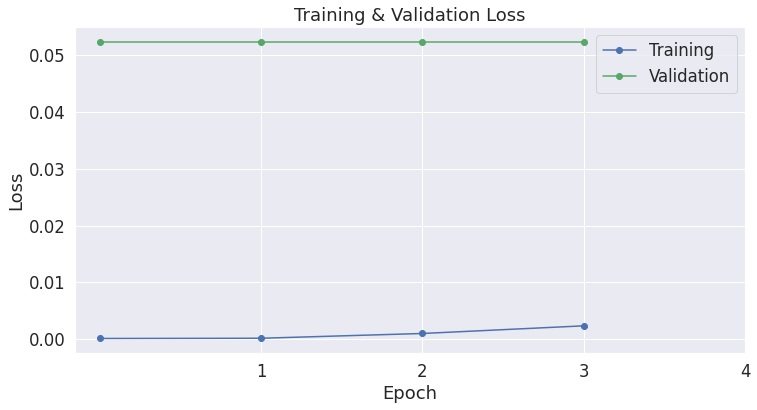

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Performance On Test Set

In [ ]:
test_data.head()

,tweet,label
0,I really miss XYZ since i have Post anime depr...,1
1,There's not much an mile depression run can't ...,1
2,How to Overcome DepressionWednesdayThoughts ap...,0
3,Real Talk Kanye has never pulled himself fully...,0
4,so it would seem. Good if you wanted your own ...,0


In [ ]:
max_len

54

In [ ]:
import torch
test_tweets, test_labels = createTrainNtest_Dataset(test_data)

In [ ]:
test_input_ids,test_attention_masks = preprocessing_Bert(test_tweets, max_len)

Loading BERT tokenizer...


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
test_attention_masks.size()

torch.Size([500, 54])

In [ ]:
test_input_ids,test_attention_masks

In [ ]:
from torch.utils.data import TensorDataset
t_labels = torch.tensor(test_labels)

# Combine the training inputs into a TensorDataset.
prediction_data = TensorDataset(test_input_ids, test_attention_masks, t_labels)

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16
# For Prediction the order doesn't matter, so we'll just read them sequentially.
prediction_dataloader = DataLoader(
            prediction_data, # The test samples.
            sampler = SequentialSampler(prediction_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
prediction_dataloader


## Evaluate on Test set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10 test sentences...
    DONE.


In [1]:
# Compute predicted probabilities on the test set

# Get predictions from the probabilities
threshold = 0.992
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

In [ ]:
def eval(model, prediction_dataloader):
    # Prediction on test set

    print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

      logits = outputs[0]


      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      print('hjgggjjg',logits)
      # Store predictions and true labels
      predictions = predictions.append(logits)
      true_labels = true_labels.append(label_ids)

    print('    DONE.')
    return predictions,true_labels

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

Accuracy: 79.40%
F1 score: 74.19%
Precision: 59.44%
Recall: 98.67%
Accuracy 0.79


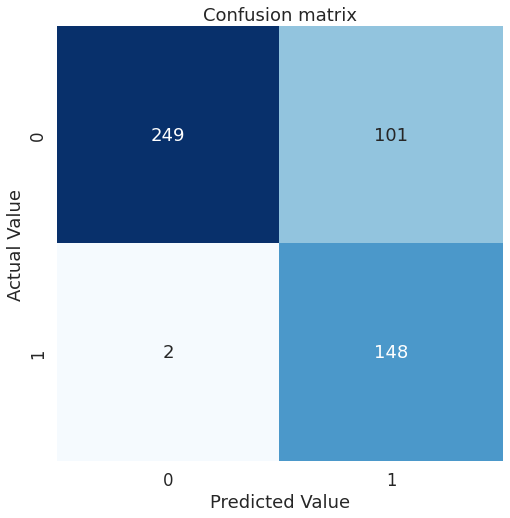

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       350
           1       0.59      0.99      0.74       150

    accuracy                           0.79       500
   macro avg       0.79      0.85      0.79       500
weighted avg       0.87      0.79      0.80       500



In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')
f1 = f1_score(flat_true_labels, flat_predictions)
print(f'F1 score: {f1*100:.2f}%')
precision = precision_score(flat_true_labels, flat_predictions)
print(f'Precision: {precision*100:.2f}%')
recall = recall_score(flat_true_labels, flat_predictions)
print(f'Recall: {recall*100:.2f}%')

c_matrix =confusion_matrix(flat_true_labels,flat_predictions)
clr = classification_report(flat_true_labels,flat_predictions)
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy", round(accuracy,2) )
plt.figure(figsize=(8,8))
sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion matrix")
plt.show()
print(clr)

AUC: 0.8785


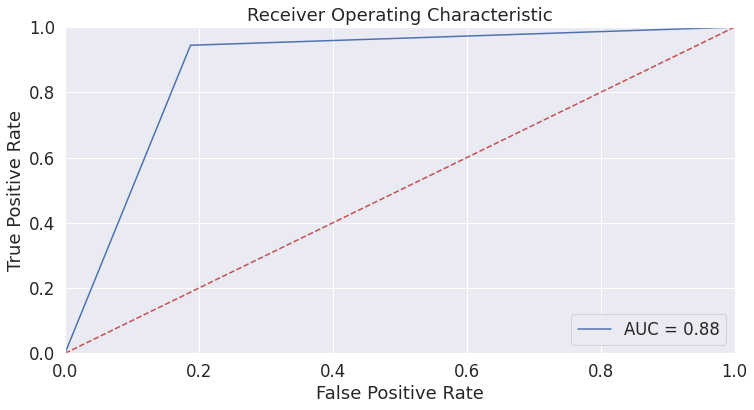

In [ ]:
fpr, tpr, threshold = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')


# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.729


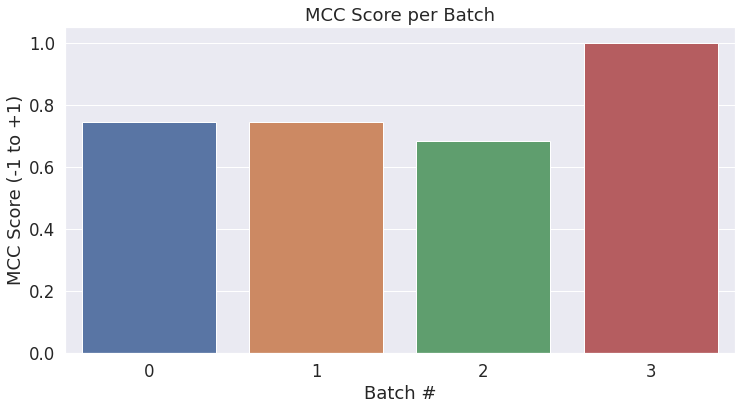

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()